In [1]:
!pip install hdbscan

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
from sklearn.datasets import fetch_20newsgroups
import numpy as np
import pandas as pd
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import DBSCAN
import hdbscan
import warnings
warnings.filterwarnings("ignore")
from sklearn.cluster import KMeans
from sklearn.metrics.cluster import contingency_matrix

In [3]:
class1 = ["comp.graphics", "comp.os.ms-windows.misc", "comp.sys.ibm.pc.hardware", "comp.sys.mac.hardware"]
class2 = ["rec.autos", "rec.motorcycles", "rec.sport.baseball", "rec.sport.hockey"]
x1 = fetch_20newsgroups(subset='all', remove=('headers', 'footers'), categories=class1, shuffle=True, random_state=42)
x2 = fetch_20newsgroups(subset='all', remove=('headers', 'footers'), categories=class2, shuffle=True, random_state=42)
x = x1.data+x2.data
y = []
for i in range(len(x1.data)):
  y.append(0)
for i in range(len(x2.data)):
  y.append(1)
y = np.array(y)

# Question 1

In [3]:
import re
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    texter = re.sub(r"<br />", " ", text)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = texter.lower()
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

In [4]:
import nltk
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction import text
stop_words_skt = text.ENGLISH_STOP_WORDS
from nltk.corpus import stopwords
stop_words_en = stopwords.words('english')
from sklearn.feature_extraction.text import CountVectorizer
from string import punctuation
combined_stopwords = set.union(set(stop_words_en),set(punctuation),set(stop_words_skt))

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
x_clean = [clean(i) for i in x]

In [7]:
count_vect = CountVectorizer(stop_words=combined_stopwords, min_df=3, max_df=0.7)
X_counts = count_vect.fit_transform(x_clean)
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)
print(X_tfidf.shape)

(7882, 21798)


# Question 2

In [15]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
def plot_mat(mat, xticklabels = None, yticklabels = None, pic_fname = None, size=(-1,-1), if_show_values = True,
             colorbar = True, grid = 'k', xlabel = None, ylabel = None, title = None, vmin=None, vmax=None):
    if size == (-1, -1):
        size = (mat.shape[1] / 3, mat.shape[0] / 3)

    fig = plt.figure(figsize=size)
    ax = fig.add_subplot(1,1,1)

    # im = ax.imshow(mat, cmap=plt.cm.Blues)
    im = ax.pcolor(mat, cmap=plt.cm.Blues, linestyle='-', linewidth=0.5, edgecolor=grid, vmin=vmin, vmax=vmax)
    
    if colorbar:
        plt.colorbar(im,fraction=0.046, pad=0.06)
    # tick_marks = np.arange(len(classes))
    # Ticks
    lda_num_topics = mat.shape[0]
    nmf_num_topics = mat.shape[1]
    yticks = np.arange(lda_num_topics)
    xticks = np.arange(nmf_num_topics)
    ax.set_xticks(xticks + 0.5)
    ax.set_yticks(yticks + 0.5)
    if xticklabels is None:
        xticklabels = [str(i) for i in xticks]
    if yticklabels is None:
        yticklabels = [str(i) for i in yticks]
    ax.set_xticklabels(xticklabels)
    ax.set_yticklabels(yticklabels)

    # Minor ticks
    # ax.set_xticks(xticks, minor=True);
    # ax.set_yticks(yticks, minor=True);
    # ax.set_xticklabels([], minor=True)
    # ax.set_yticklabels([], minor=True)

    # ax.grid(which='minor', color='k', linestyle='-', linewidth=0.5)

    # tick labels on all four sides
    ax.tick_params(labelright = True, labeltop = False)

    if ylabel:
        plt.ylabel(ylabel, fontsize=15)
    if xlabel:
        plt.xlabel(xlabel, fontsize=15)
    if title:
        plt.title(title, fontsize=15)

    # im = ax.imshow(mat, interpolation='nearest', cmap=plt.cm.Blues)
    ax.invert_yaxis()

    # thresh = mat.max() / 2

    def show_values(pc, fmt="%.3f", **kw):
        pc.update_scalarmappable()
        ax = pc.axes
        for p, color, value in itertools.zip_longest(pc.get_paths(), pc.get_facecolors(), pc.get_array()):
            x, y = p.vertices[:-2, :].mean(0)
            if np.all(color[:3] > 0.5):
                color = (0.0, 0.0, 0.0)
            else:
                color = (1.0, 1.0, 1.0)
            ax.text(x, y, fmt % value, ha="center", va="center", color=color, **kw, fontsize=10)

    if if_show_values:
        show_values(im)
    # for i, j in itertools.product(range(mat.shape[0]), range(mat.shape[1])):
    #     ax.text(j, i, "{:.2f}".format(mat[i, j]), fontsize = 4,
    #              horizontalalignment="center",
    #              color="white" if mat[i, j] > thresh else "black")

    plt.tight_layout()
    if pic_fname:
        plt.savefig(pic_fname, dpi=300, transparent=True)
    plt.show()
    plt.close()

In [9]:
from sklearn.cluster import KMeans
y_pred = KMeans(n_clusters=2, max_iter=1000, n_init=30, random_state=0).fit_predict(X_tfidf)

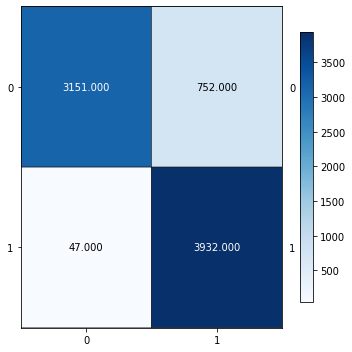

In [10]:
from sklearn.metrics.cluster import contingency_matrix
plot_mat(contingency_matrix(y,y_pred), size=(5,5))

# Question 3

In [11]:
from sklearn.metrics.cluster import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score
def five_metrics(y,y_pred):
  print("Homogeneity: ", homogeneity_score(y,y_pred))
  print("Completeness: ",completeness_score(y,y_pred))
  print("V-measure: ",v_measure_score(y,y_pred))
  print("Adjusted Rand Index: ",adjusted_rand_score(y,y_pred))
  print("Adjusted mutual information score: ",adjusted_mutual_info_score(y,y_pred))

five_metrics(y,y_pred)

Homogeneity:  0.5774035409987348
Completeness:  0.5926514149929692
V-measure:  0.5849281246876363
Adjusted Rand Index:  0.6355770387145221
Adjusted mutual information score:  0.5848896291295917


# Question 4

In [12]:
from sklearn.decomposition import TruncatedSVD
k = [1, 10, 50, 100, 200, 500, 1000]
explained_variance_ratio = []
for k in k:
    svd = TruncatedSVD(n_components=k)
    explained_variance_ratio.append(svd.fit(X_tfidf).explained_variance_ratio_.sum())

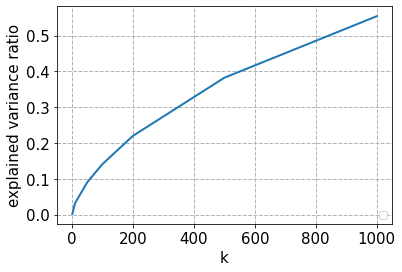

In [13]:
k = [1, 10, 50, 100, 200, 500, 1000]
plt.show()
fig, ax = plt.subplots()
ax.plot(k, explained_variance_ratio, lw=2)
ax.grid(color='0.7', linestyle='--', linewidth=1)
ax.set_xlabel('k',fontsize=15)
ax.set_ylabel('explained variance ratio',fontsize=15)
ax.legend(loc="lower right")
for label in ax.get_xticklabels()+ax.get_yticklabels():
    label.set_fontsize(15)

# Question 5

In [14]:
def append_five_metrics(y,y_pred):
    Homogeneity.append(homogeneity_score(y,y_pred))
    Completeness.append(completeness_score(y,y_pred))
    V_measure.append(v_measure_score(y,y_pred))
    Adjusted_Rand_Index.append(adjusted_rand_score(y,y_pred))
    Adjusted_mutual_information_score.append(adjusted_mutual_info_score(y,y_pred))

In [15]:
#SVD
r = [1, 2, 3, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]
Homogeneity = []
Completeness = []
V_measure = []
Adjusted_Rand_Index = []
Adjusted_mutual_information_score = []
k_means = KMeans(n_clusters=2, max_iter=1000, n_init=30, random_state=0)
for i in r:
    svd = TruncatedSVD(n_components=i, random_state = 42)
    lsi_svd = svd.fit_transform(X_tfidf)
    y_pred = k_means.fit_predict(lsi_svd)
    append_five_metrics(y,y_pred)

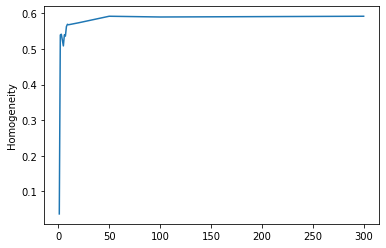

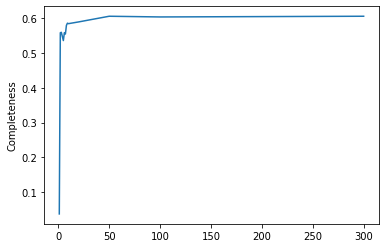

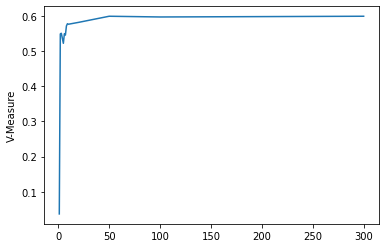

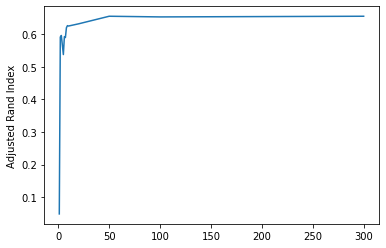

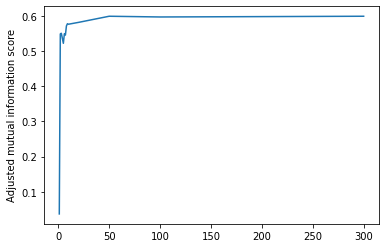

In [16]:
plot_label = ["Homogeneity", "Completeness", "V-Measure", "Adjusted Rand Index", "Adjusted mutual information score"]
plot_value = [Homogeneity, Completeness, V_measure, Adjusted_Rand_Index, Adjusted_mutual_information_score]
for i in range(5):
   plt.plot(r, plot_value[i])
   plt.ylabel(plot_label[i])
   plt.show() 

In [17]:
# Good choice of r = 100
svd = TruncatedSVD(n_components=100, random_state = 42)
lsi_svd = svd.fit_transform(X_tfidf)
y_pred = k_means.fit_predict(lsi_svd)
five_metrics(y,y_pred)

Homogeneity:  0.5899537259516914
Completeness:  0.6034440906314431
V-measure:  0.5966226596439396
Adjusted Rand Index:  0.6526858094952921
Adjusted mutual information score:  0.5965853125399415


In [ ]:
#NMF
r = [1, 2, 3, 5, 6, 7, 8, 9, 10, 20, 50, 100, 300]
Homogeneity = []
Completeness = []
V_measure = []
Adjusted_Rand_Index = []
Adjusted_mutual_information_score = []
k_means = KMeans(n_clusters=2, max_iter=1000, n_init=30, random_state=0)
for i in r:
    nmf = NMF(n_components=i, init='random', random_state=42)
    lsi_nmf =  nmf.fit_transform(X_tfidf)
    y_pred = k_means.fit_predict(lsi_nmf)
    append_five_metrics(y,y_pred)

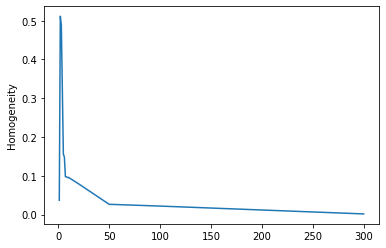

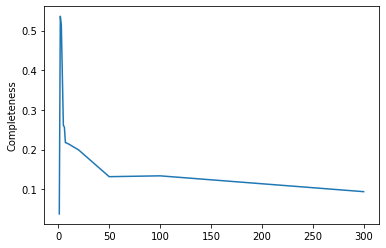

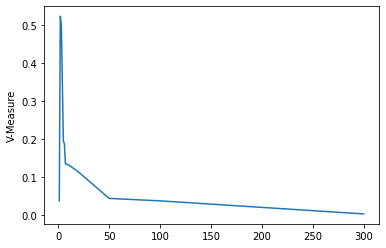

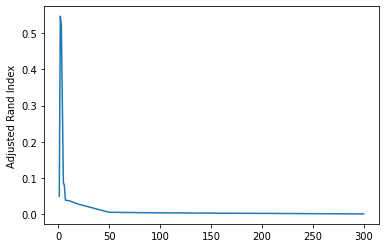

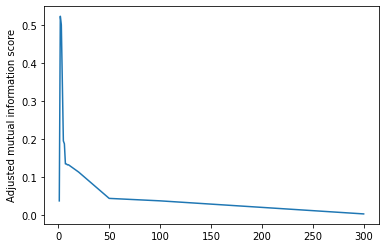

In [ ]:
plot_label = ["Homogeneity", "Completeness", "V-Measure", "Adjusted Rand Index", "Adjusted mutual information score"]
plot_value = [Homogeneity, Completeness, V_measure, Adjusted_Rand_Index, Adjusted_mutual_information_score]
for i in range(5):
   plt.plot(r, plot_value[i])
   plt.ylabel(plot_label[i])
   plt.show() 

In [ ]:
# Good choice of r = 2
nmf = NMF(n_components=2, init='random', random_state=42)
lsi_nmf =  nmf.fit_transform(X_tfidf)
y_pred = k_means.fit_predict(lsi_nmf)
five_metrics(y,y_pred)

Homogeneity:  0.5115236327667606
Completeness:  0.5361058705090008
V-measure:  0.5235263450921855
Adjusted Rand Index:  0.5474158685233216
Adjusted mutual information score:  0.5234816993809943


#Question 6

# Question 7

# Question 8

In [ ]:
# best choice of r for K-Means clustering with SVD is 100
lsi_svd = TruncatedSVD(n_components=100, random_state = 42).fit_transform(X_tfidf)
y_pred_svd = k_means.fit_predict(lsi_svd)

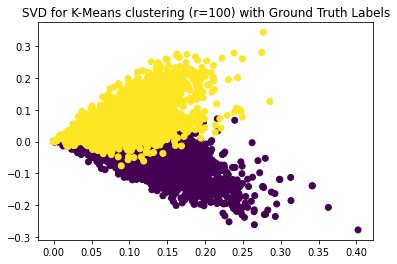

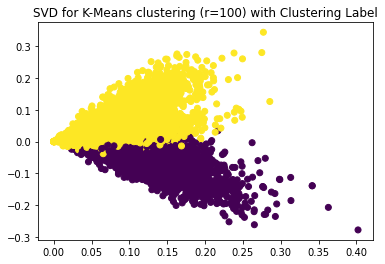

In [ ]:
# SVD with r = 100 with Ground Truth Labels
a, b = [lsi_svd[:, 0], lsi_svd[:, 1]]
plt.scatter(a, b, c=y)
plt.title("SVD for K-Means clustering (r=100) with Ground Truth Labels")
plt.show()
# SVD with r = 100 with Clustering Label
plt.scatter(a, b, c=y_pred_svd)
plt.title("SVD for K-Means clustering (r=100) with Clustering Label")
plt.show()

In [ ]:
# best choice of r for K-Means clustering with NMF is 2
nmf = NMF(n_components=2, init='random', random_state=42)
lsi_nmf = NMF(n_components=2, init='random', random_state=42).fit_transform(X_tfidf)
y_pred_nmf = k_means.fit_predict(lsi_nmf)

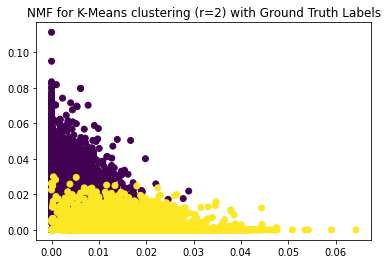

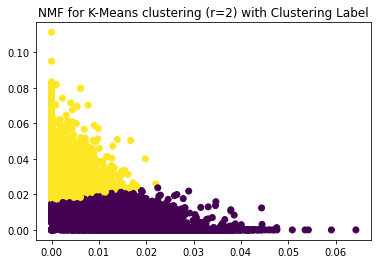

In [ ]:
# NMF with r = 2 with Ground Truth Labels
a, b = [lsi_nmf[:, 0],lsi_nmf[:, 1]]
plt.scatter(a, b, c=y)
plt.title("NMF for K-Means clustering (r=2) with Ground Truth Labels")
plt.show()
# NMF with r = 2 with Clustering Label
plt.scatter(a, b, c=y_pred_nmf)
plt.title("NMF for K-Means clustering (r=2) with Clustering Label")
plt.show()

# Question 10

In [8]:
X,Y = fetch_20newsgroups( return_X_y=True,subset='all', remove=('headers', 'footers'), shuffle=True, random_state=42)

In [9]:
x_clean = [clean(i) for i in X]
count_vect = CountVectorizer(stop_words=combined_stopwords, min_df=3, max_df=0.7)
X_counts = count_vect.fit_transform(x_clean)
from sklearn.feature_extraction.text import TfidfTransformer
tfidf_transformer = TfidfTransformer()
X_tfidf = tfidf_transformer.fit_transform(X_counts)
print(X_tfidf.shape)

(18846, 42170)


In [20]:
# svd
k_means = KMeans(n_clusters=20, max_iter=1000, n_init=30, random_state=0)
svd = TruncatedSVD(n_components=100, random_state = 42)
y_pred = k_means.fit_predict(svd.fit_transform(X_tfidf))

In [11]:
from sklearn.metrics.cluster import homogeneity_score, completeness_score, v_measure_score, adjusted_rand_score, adjusted_mutual_info_score

def five_metrics(y,y_pred):
  print("Homogeneity: ", homogeneity_score(y,y_pred))
  print("Completeness: ",completeness_score(y,y_pred))
  print("V-measure: ",v_measure_score(y,y_pred))
  print("Adjusted Rand Index: ",adjusted_rand_score(y,y_pred))
  print("Adjusted mutual information score: ",adjusted_mutual_info_score(y,y_pred))

In [13]:
import numpy as np
from scipy.optimize import linear_sum_assignment
from sklearn.metrics import confusion_matrix

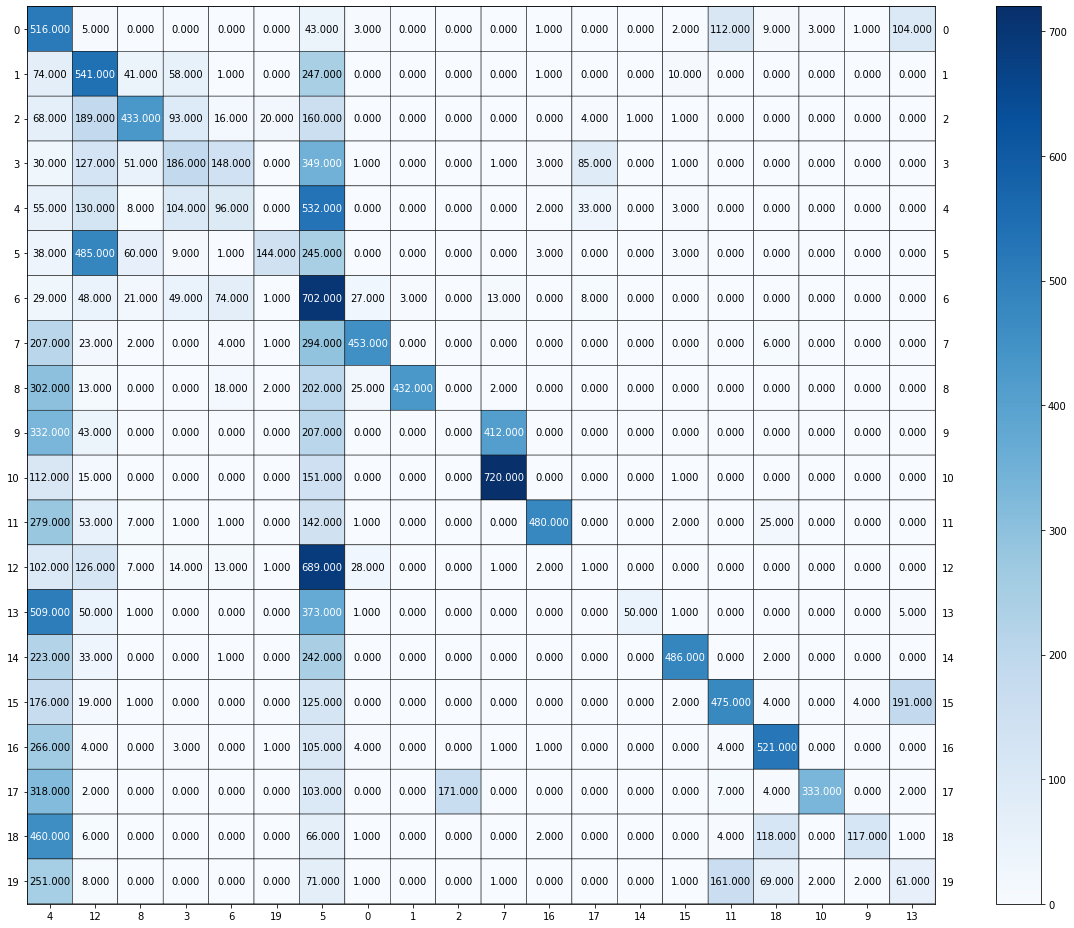

In [23]:
cm = confusion_matrix(Y,y_pred)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols,yticklabels=rows, size=(15,13))

In [24]:
five_metrics(Y,y_pred)

Homogeneity:  0.36344527780811314
Completeness:  0.4636394506312786
V-measure:  0.40747353479839793
Adjusted Rand Index:  0.12180153342657082
Adjusted mutual information score:  0.4053011885269787


In [25]:
# nmf
k_means = KMeans(n_clusters=20, max_iter=1000, n_init=30, random_state=0)
nmf = NMF(n_components=20, init='random', random_state=42)
y_pred = k_means.fit_predict(nmf.fit_transform(X_tfidf))

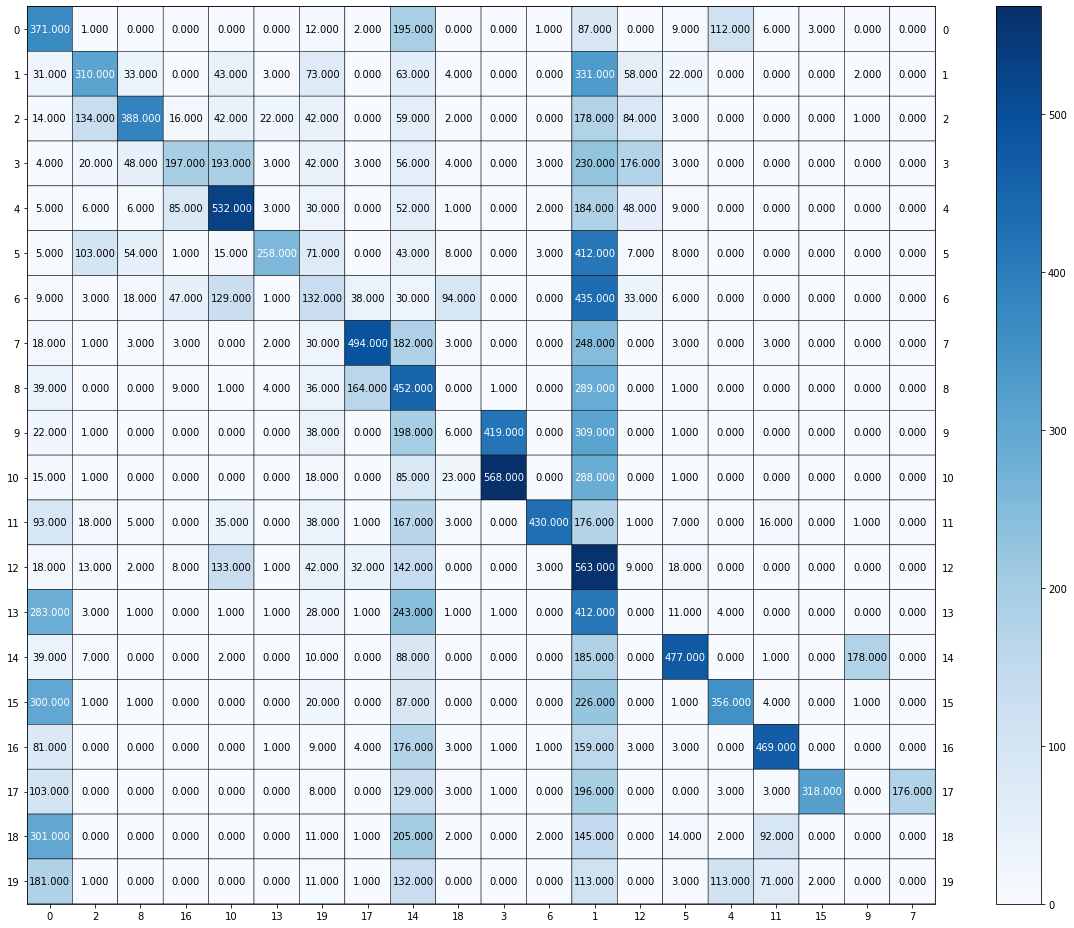

In [26]:
cm = confusion_matrix(Y,y_pred)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,13))

In [27]:
five_metrics(Y,y_pred)

Homogeneity:  0.33395741408685753
Completeness:  0.39777564656828923
V-measure:  0.36308357092882243
Adjusted Rand Index:  0.10406823198250942
Adjusted mutual information score:  0.3608372984487715


# Question 11


In [5]:
!pip install umap-learn

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import umap.umap_ as umap

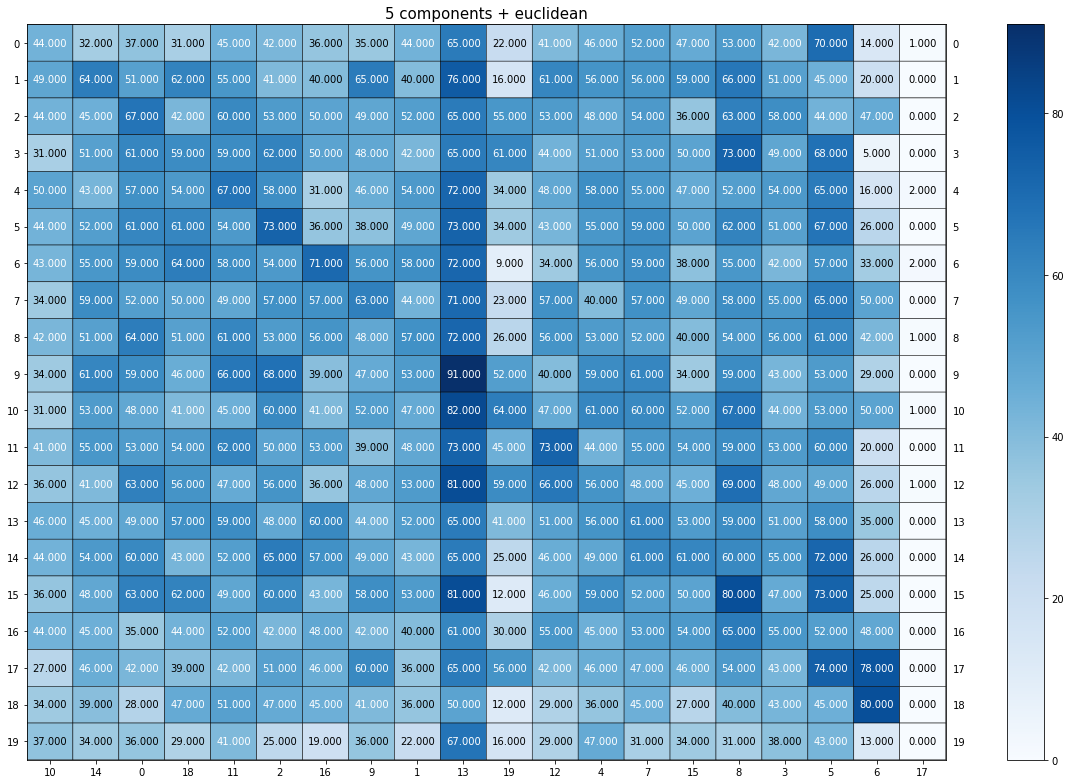

Homogeneity:  0.006963310345264541
Completeness:  0.007098643880587983
V-measure:  0.007030325881757074
Adjusted Rand Index:  0.000860714947023135
Adjusted mutual information score:  0.0038033666578713276


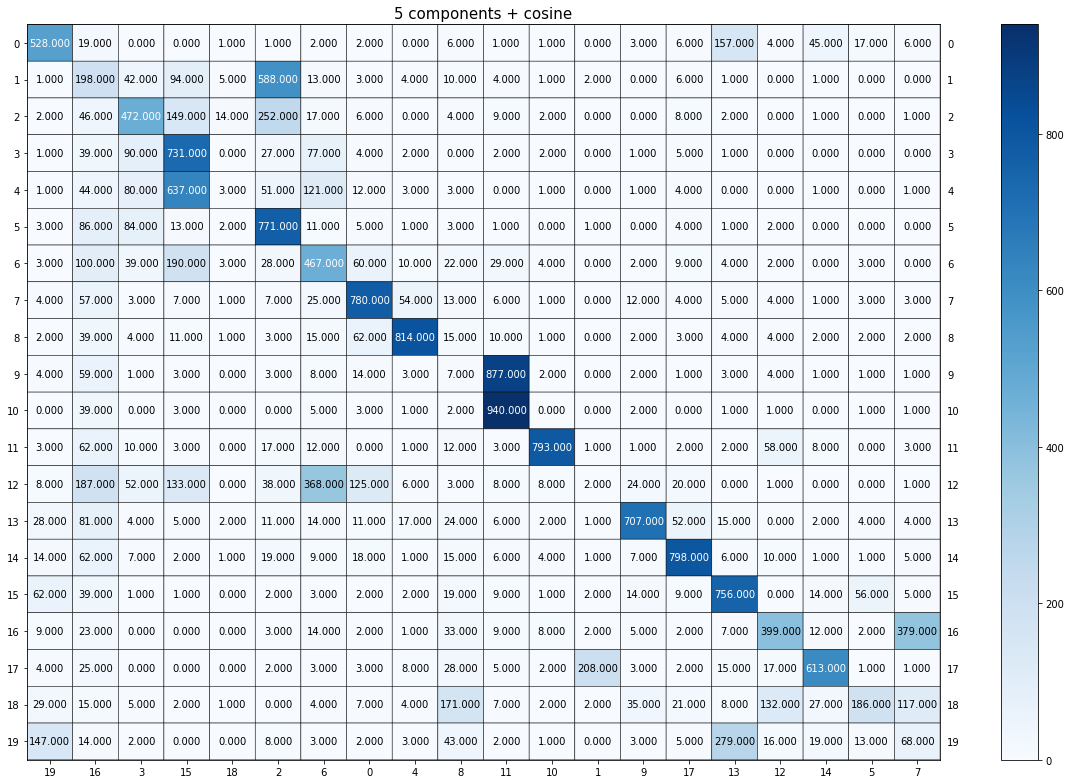

Homogeneity:  0.5579646383397878
Completeness:  0.5897530610088147
V-measure:  0.5734186265182245
Adjusted Rand Index:  0.42012638848880346
Adjusted mutual information score:  0.5719905310550398


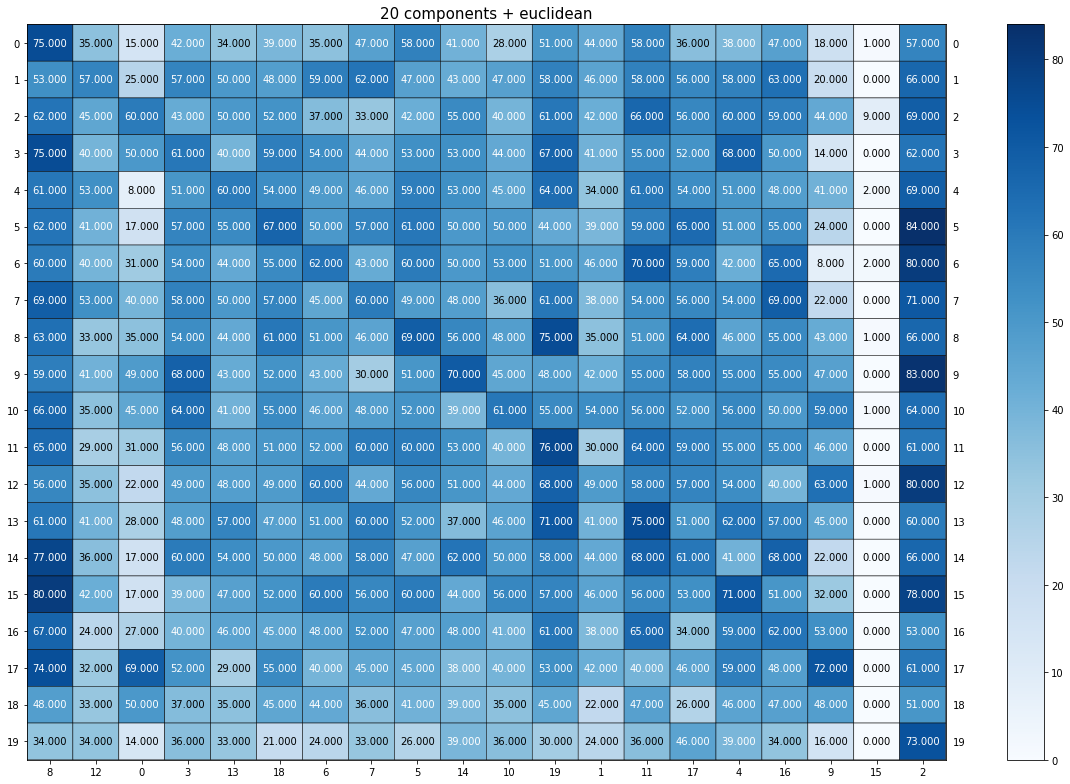

Homogeneity:  0.006727234238865325
Completeness:  0.006856830499122388
V-measure:  0.006791414174403483
Adjusted Rand Index:  0.0007462319543346768
Adjusted mutual information score:  0.0035326420178268107


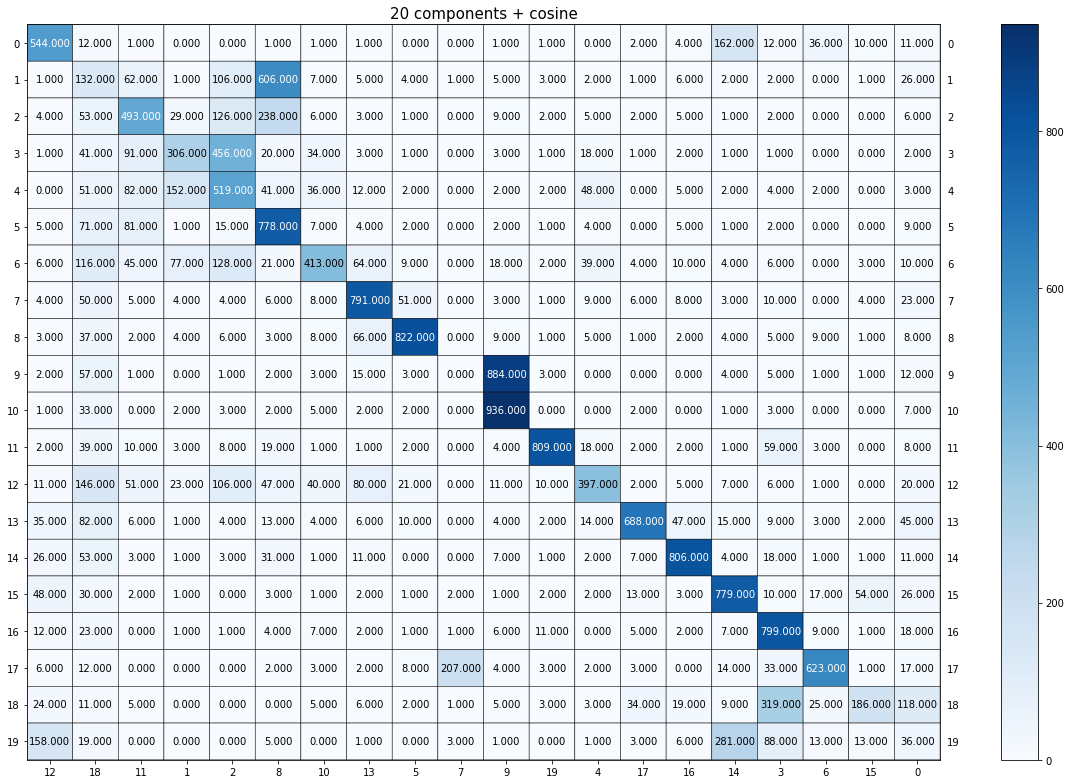

Homogeneity:  0.5727266672477204
Completeness:  0.5950927361971373
V-measure:  0.5836955243253182
Adjusted Rand Index:  0.44247696596196257
Adjusted mutual information score:  0.5823243993906418


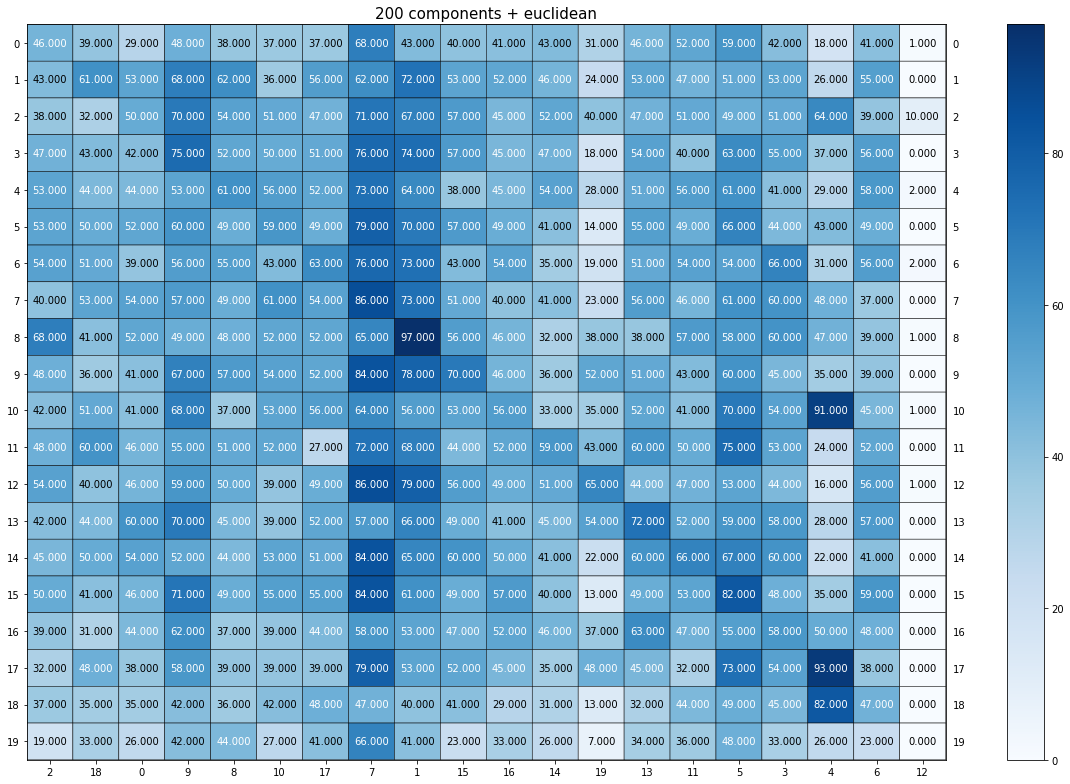

Homogeneity:  0.007043579932128244
Completeness:  0.007179839386213435
V-measure:  0.007111056980711039
Adjusted Rand Index:  0.0009614342903204385
Adjusted mutual information score:  0.0038519780440671642


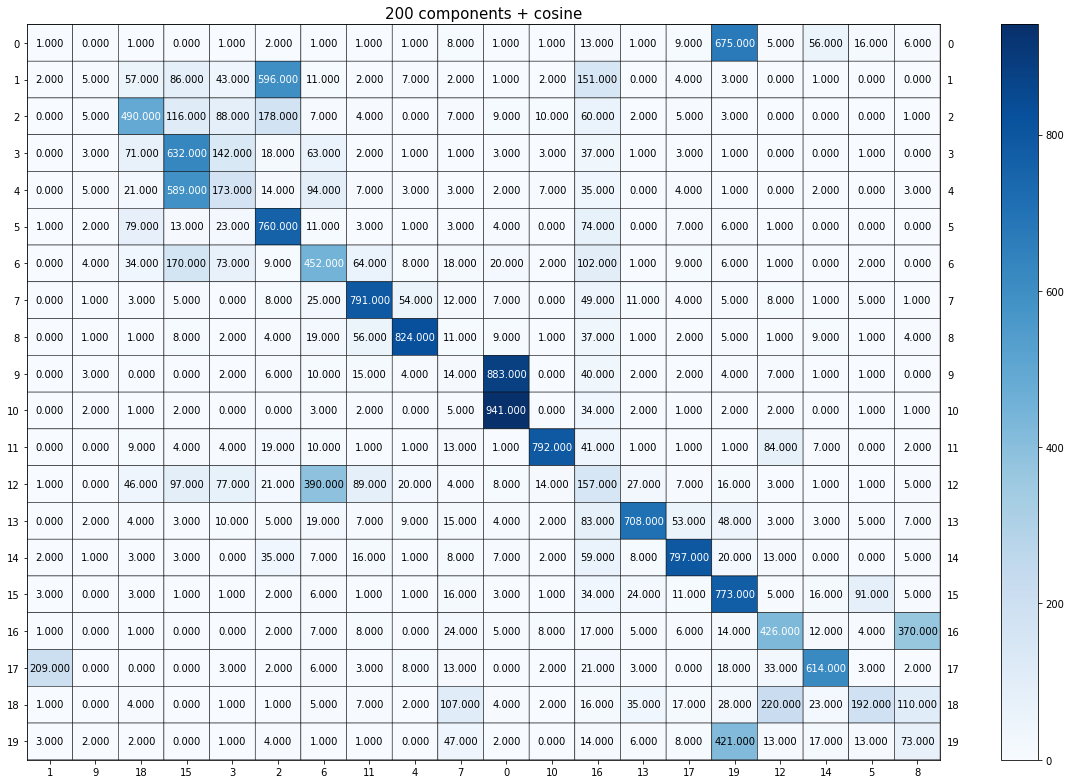

Homogeneity:  0.5583331319425638
Completeness:  0.5918004325527025
V-measure:  0.5745798561006596
Adjusted Rand Index:  0.42152880386103947
Adjusted mutual information score:  0.5731539609712347


In [16]:
n_components = [5, 20, 200]
metrics = ['euclidean', 'cosine']
for n in n_components:
  for m in metrics:
    umap_model = umap.UMAP(n_components=n, metric=m)
    kmeans = KMeans(n_clusters=20, init='random', n_init=30, max_iter=1000, random_state=0)
    y_pred = kmeans.fit_predict(umap_model.fit_transform(X_tfidf))
    cm = confusion_matrix(Y,y_pred)
    rows, cols = linear_sum_assignment(cm, maximize=True)
    plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols,title = str(n) + " components + "+str(m),yticklabels=rows, size=(15,11))
    five_metrics(Y,y_pred)

# Question 14

In [ ]:
umap_model = umap.UMAP(n_components=5, metric='cosine')
aggcluster = AgglomerativeClustering(n_clusters=20, linkage='ward')
y_pred = aggcluster.fit_predict(umap_model.fit_transform(X_tfidf))
five_metrics(Y, y_pred)

Homogeneity:  0.5742676139462952
Completeness:  0.6040194215922895
V-measure:  0.5887679004402774
Adjusted Rand Index:  0.43927922956764104
Adjusted mutual information score:  0.5873940585213347


In [ ]:
umap_model = umap.UMAP(n_components=5, metric='cosine')
aggcluster = AgglomerativeClustering(n_clusters=20, linkage='single')
y_pred = aggcluster.fit_predict(umap_model.fit_transform(X_tfidf))
five_metrics(Y, y_pred)

Homogeneity:  0.10632194391571805
Completeness:  0.6875800649762177
V-measure:  0.18416592548493746
Adjusted Rand Index:  0.020932493306462702
Adjusted mutual information score:  0.1804030253895555


# Question 15

In [ ]:
min_clust_size = [20,100,200]
for m in min_clust_size:
  hdb_clust = hdbscan.HDBSCAN(min_cluster_size=m)
  y_pred = hdb_clust.fit_predict(umap_model.fit_transform(X_tfidf))
  print(m)
  five_metrics(Y, y_pred)

20
Homogeneity:  0.4213436898781575
Completeness:  0.43394333368258675
V-measure:  0.42755070607911316
Adjusted Rand Index:  0.06949144572608194
Adjusted mutual information score:  0.4149583559942783
100
Homogeneity:  0.4336789202796464
Completeness:  0.6375099981242074
V-measure:  0.5162014709150505
Adjusted Rand Index:  0.21859244455476776
Adjusted mutual information score:  0.5151237897905137
200
Homogeneity:  0.41815386406777416
Completeness:  0.6154862906128278
V-measure:  0.49798369294200345
Adjusted Rand Index:  0.2115996277850882
Adjusted mutual information score:  0.4969685477987435


# QUestion 16

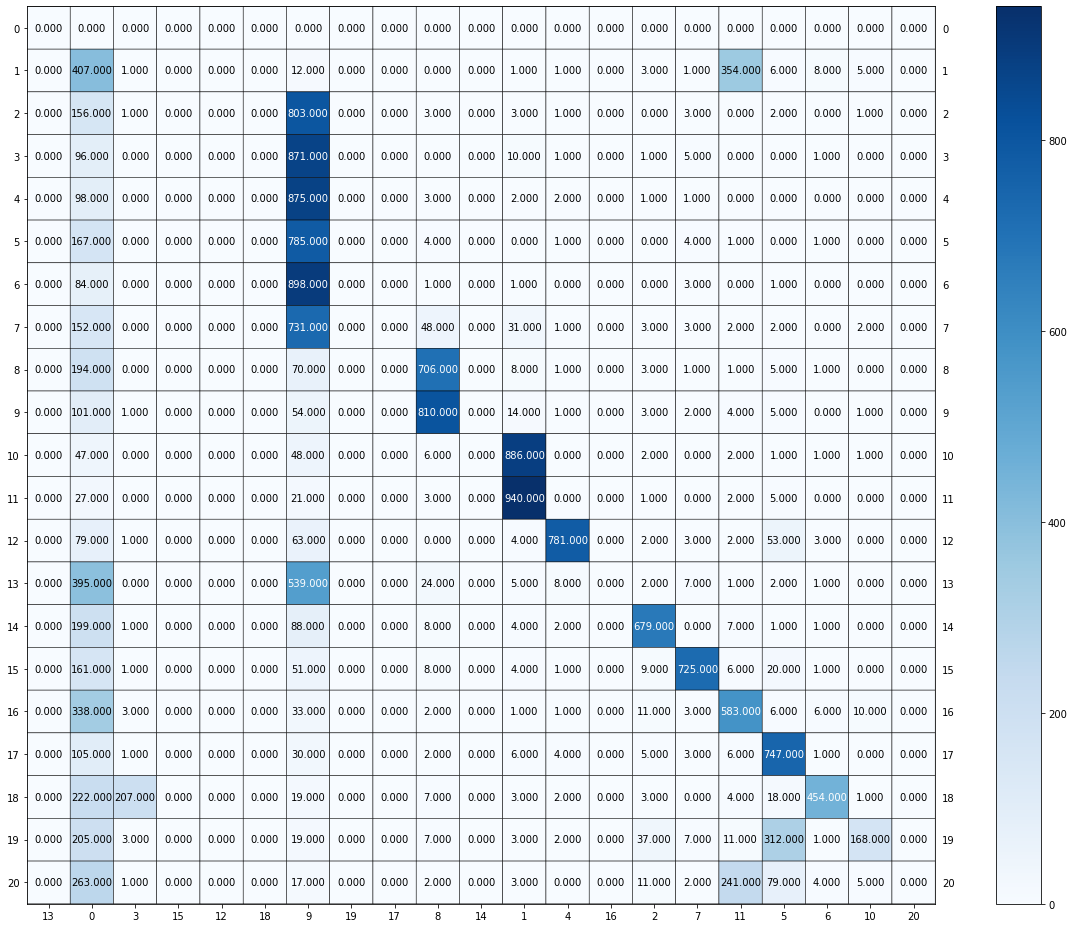

In [ ]:
# best clustering size = 100
hdb_clust = hdbscan.HDBSCAN(min_cluster_size=100)
y_pred = hdb_clust.fit_predict(umap_model.fit_transform(X_tfidf))

cm = confusion_matrix(Y,y_pred)
rows, cols = linear_sum_assignment(cm, maximize=True)
plot_mat(cm[rows[:, np.newaxis], cols], xticklabels=cols, yticklabels=rows, size=(15,13))

In [ ]:
sample_list = hdb_clust.labels_
def occurrence(a):
  k = {}
  for i in a:
    if i in k:
      k[i] +=1
    else:
      k[i] =1
  return k
print(occurrence(sample_list))

{0: 1929, 8: 6027, 2: 221, -1: 3496, 1: 776, 3: 810, 4: 1265, 7: 1644, 6: 773, 10: 1227, 5: 484, 9: 194}


# Question 17:

## SVD

In [ ]:
# SVD + K-mean:
SVD_list = [5,20,200]
K_mean_list = [10,20,50]
history = {}

for s in SVD_list:
  for k in K_mean_list:
    k_means = KMeans(n_clusters=k, max_iter=1000, n_init=30, random_state=0)
    svd = TruncatedSVD(n_components=s, random_state = 42)
    y_pred = k_means.fit_predict(svd.fit_transform(X_tfidf))
    history["SVD" + str(s) + " + "+ "K_MEAN + " + str(k)] = adjusted_rand_score(Y,y_pred)


In [ ]:
# SVD + AGG:
SVD_list = [5,20,200]


for s in SVD_list:
    svd = TruncatedSVD(n_components=s, random_state = 42)
    aggcluster = AgglomerativeClustering(n_clusters=20, linkage='ward')
    y_pred = aggcluster.fit_predict(svd.fit_transform(X_tfidf))
    print("SVD" + str(s) + " + "+ "AGG + 20" )
    history["SVD" + str(s) + " + "+ "AGG + 20"] = adjusted_rand_score(Y,y_pred)


SVD5 + AGG + 20
SVD20 + AGG + 20
SVD200 + AGG + 20


In [ ]:
history

{'SVD5 + K_MEAN + 10': 0.09679702072269666,
 'SVD5 + K_MEAN + 20': 0.13344166546423533,
 'SVD5 + K_MEAN + 50': 0.1089927051735795,
 'SVD20 + K_MEAN + 10': 0.08588229350837168,
 'SVD20 + K_MEAN + 20': 0.12297443619840195,
 'SVD20 + K_MEAN + 50': 0.15404690479353797,
 'SVD200 + K_MEAN + 10': 0.09918873421997113,
 'SVD200 + K_MEAN + 20': 0.0985557850547592,
 'SVD200 + K_MEAN + 50': 0.13006995979150218,
 'SVD5 + AGG + 20': 0.11567593953990528,
 'SVD20 + AGG + 20': 0.16830745559066143,
 'SVD200 + AGG + 20': 0.12443854396797484}

In [ ]:
# SVD + HDB:
SVD_list = [5,20,200]

min_clust_size = [100,200]
for m in min_clust_size:
  for s in SVD_list:
    svd = TruncatedSVD(n_components=s, random_state = 42)
    hdb_clust = hdbscan.HDBSCAN(min_cluster_size=m)
    y_pred = hdb_clust.fit_predict(svd.fit_transform(X_tfidf))
    print("SVD" + str(s) + " + "+ "HDB + "+str(m))
    history["SVD" + str(s) + " + "+ "HDB + " + str(m)] = adjusted_rand_score(Y,y_pred)


SVD5 + HDB + 100
SVD20 + HDB + 100
SVD200 + HDB + 100
SVD5 + HDB + 200
SVD20 + HDB + 200
SVD200 + HDB + 200


In [ ]:
history

{'SVD5 + K_MEAN + 10': 0.09679702072269666,
 'SVD5 + K_MEAN + 20': 0.13344166546423533,
 'SVD5 + K_MEAN + 50': 0.1089927051735795,
 'SVD20 + K_MEAN + 10': 0.08588229350837168,
 'SVD20 + K_MEAN + 20': 0.12297443619840195,
 'SVD20 + K_MEAN + 50': 0.15404690479353797,
 'SVD200 + K_MEAN + 10': 0.09918873421997113,
 'SVD200 + K_MEAN + 20': 0.0985557850547592,
 'SVD200 + K_MEAN + 50': 0.13006995979150218,
 'SVD5 + AGG + 20': 0.11567593953990528,
 'SVD20 + AGG + 20': 0.16830745559066143,
 'SVD200 + AGG + 20': 0.12443854396797484,
 'SVD5 + HDB + 100': -9.419666101039764e-06,
 'SVD20 + HDB + 100': 0.0,
 'SVD200 + HDB + 100': 0.0,
 'SVD5 + HDB + 200': 0.0,
 'SVD20 + HDB + 200': 0.0,
 'SVD200 + HDB + 200': 0.0}

## NMF

In [ ]:
# Kmeans
nmf_list = [5,20,200]
K_mean_list = [10,20,50]

for N in nmf_list:
  for k in K_mean_list:
    k_means = KMeans(n_clusters=k, max_iter=1000, n_init=30, random_state=0)
    nmf = NMF(n_components=N, init='random', random_state=42)
    y_pred = k_means.fit_predict(nmf.fit_transform(X_tfidf))
    print("nmf" + str(N) + " + "+ "k_mean + "+str(k))
    history["NMF" + str(N) + " + "+ "K_MEAN + " + str(k)] = adjusted_rand_score(Y,y_pred)


nmf5 + k_mean + 10
nmf5 + k_mean + 20
nmf5 + k_mean + 50
nmf20 + k_mean + 10
nmf20 + k_mean + 20
nmf20 + k_mean + 50


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


nmf200 + k_mean + 10


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


nmf200 + k_mean + 20


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


nmf200 + k_mean + 50


In [ ]:
history

{'SVD5 + K_MEAN + 10': 0.09679702072269666,
 'SVD5 + K_MEAN + 20': 0.13344166546423533,
 'SVD5 + K_MEAN + 50': 0.1089927051735795,
 'SVD20 + K_MEAN + 10': 0.08588229350837168,
 'SVD20 + K_MEAN + 20': 0.12297443619840195,
 'SVD20 + K_MEAN + 50': 0.15404690479353797,
 'SVD200 + K_MEAN + 10': 0.09918873421997113,
 'SVD200 + K_MEAN + 20': 0.0985557850547592,
 'SVD200 + K_MEAN + 50': 0.13006995979150218,
 'SVD5 + AGG + 20': 0.11567593953990528,
 'SVD20 + AGG + 20': 0.16830745559066143,
 'SVD200 + AGG + 20': 0.12443854396797484,
 'SVD5 + HDB + 100': -9.419666101039764e-06,
 'SVD20 + HDB + 100': 0.0,
 'SVD200 + HDB + 100': 0.0,
 'SVD5 + HDB + 200': 0.0,
 'SVD20 + HDB + 200': 0.0,
 'SVD200 + HDB + 200': 0.0,
 'NMF200 + K_MEAN + 10': 0.004249134517982495,
 'NMF200 + K_MEAN + 20': 0.035679745688306376,
 'NMF200 + K_MEAN + 50': 0.04527096828501377,
 'NMF5 + K_MEAN + 10': 0.08986787288671771,
 'NMF5 + K_MEAN + 20': 0.1035619753598765,
 'NMF5 + K_MEAN + 50': 0.09109340339245127,
 'NMF20 + K_MEAN + 

In [ ]:
# AGG
nmf_list = [5,20,200]

for N in nmf_list:
    nmf = NMF(n_components=N, init='random', random_state=42)
    aggcluster = AgglomerativeClustering(n_clusters=20, linkage='ward')
    y_pred = aggcluster.fit_predict(nmf.fit_transform(X_tfidf))
    print("nmf" + str(N) + " + "+ "AGG + "+str(k))
    history["NMF" + str(N) + " + "+ "AGG + " + str(k)] = adjusted_rand_score(Y,y_pred)


nmf5 + AGG + 50
nmf20 + AGG + 50


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


nmf200 + AGG + 50


In [ ]:
history

{'SVD5 + K_MEAN + 10': 0.09679702072269666,
 'SVD5 + K_MEAN + 20': 0.13344166546423533,
 'SVD5 + K_MEAN + 50': 0.1089927051735795,
 'SVD20 + K_MEAN + 10': 0.08588229350837168,
 'SVD20 + K_MEAN + 20': 0.12297443619840195,
 'SVD20 + K_MEAN + 50': 0.15404690479353797,
 'SVD200 + K_MEAN + 10': 0.09918873421997113,
 'SVD200 + K_MEAN + 20': 0.0985557850547592,
 'SVD200 + K_MEAN + 50': 0.13006995979150218,
 'SVD5 + AGG + 20': 0.11567593953990528,
 'SVD20 + AGG + 20': 0.16830745559066143,
 'SVD200 + AGG + 20': 0.12443854396797484,
 'SVD5 + HDB + 100': -9.419666101039764e-06,
 'SVD20 + HDB + 100': 0.0,
 'SVD200 + HDB + 100': 0.0,
 'SVD5 + HDB + 200': 0.0,
 'SVD20 + HDB + 200': 0.0,
 'SVD200 + HDB + 200': 0.0,
 'NMF200 + K_MEAN + 10': 0.004249134517982495,
 'NMF200 + K_MEAN + 20': 0.035679745688306376,
 'NMF200 + K_MEAN + 50': 0.04527096828501377,
 'NMF5 + K_MEAN + 10': 0.08986787288671771,
 'NMF5 + K_MEAN + 20': 0.1035619753598765,
 'NMF5 + K_MEAN + 50': 0.09109340339245127,
 'NMF20 + K_MEAN + 

In [ ]:
# NMF + HDBnmf_list = [5,20,200]
nmf_list = [5,20,200]

min_clust_size = [100,200]

for m in min_clust_size:
  for N in nmf_list:
    nmf = NMF(n_components=N, init='random', random_state=42)
    hdb_clust = hdbscan.HDBSCAN(min_cluster_size=m)
    y_pred = hdb_clust.fit_predict(nmf.fit_transform(X_tfidf))
    print("nmf" + str(N) + " + "+ "HDB + "+str(m))
    history["NMF" + str(N) + " + "+ "HDB + " + str(m)] = adjusted_rand_score(Y,y_pred)


nmf5 + HDB + 100
nmf20 + HDB + 100


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


nmf200 + HDB + 100
nmf5 + HDB + 200
nmf20 + HDB + 200


/usr/local/lib/python3.8/dist-packages/sklearn/decomposition/_nmf.py:1637: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


nmf200 + HDB + 200


In [ ]:
history

{'SVD5 + K_MEAN + 10': 0.09679702072269666,
 'SVD5 + K_MEAN + 20': 0.13344166546423533,
 'SVD5 + K_MEAN + 50': 0.1089927051735795,
 'SVD20 + K_MEAN + 10': 0.08588229350837168,
 'SVD20 + K_MEAN + 20': 0.12297443619840195,
 'SVD20 + K_MEAN + 50': 0.15404690479353797,
 'SVD200 + K_MEAN + 10': 0.09918873421997113,
 'SVD200 + K_MEAN + 20': 0.0985557850547592,
 'SVD200 + K_MEAN + 50': 0.13006995979150218,
 'SVD5 + AGG + 20': 0.11567593953990528,
 'SVD20 + AGG + 20': 0.16830745559066143,
 'SVD200 + AGG + 20': 0.12443854396797484,
 'SVD5 + HDB + 100': -9.419666101039764e-06,
 'SVD20 + HDB + 100': 0.0,
 'SVD200 + HDB + 100': 0.0,
 'SVD5 + HDB + 200': 0.0,
 'SVD20 + HDB + 200': 0.0,
 'SVD200 + HDB + 200': 0.0,
 'NMF200 + K_MEAN + 10': 0.004249134517982495,
 'NMF200 + K_MEAN + 20': 0.035679745688306376,
 'NMF200 + K_MEAN + 50': 0.04527096828501377,
 'NMF5 + K_MEAN + 10': 0.08986787288671771,
 'NMF5 + K_MEAN + 20': 0.1035619753598765,
 'NMF5 + K_MEAN + 50': 0.09109340339245127,
 'NMF20 + K_MEAN + 

#UMAP

In [ ]:
#UMAP + Kmeans
n_components = [5,20,200]
K_mean_list = [10,20,50]

for n in n_components:
    for k in K_mean_list:
      umap_model = umap.UMAP(n_components=n, metric="cosine")
      kmeans = KMeans(n_clusters=k, init='random', n_init=30, max_iter=1000, random_state=0)
      y_pred = kmeans.fit_predict(umap_model.fit_transform(X_tfidf))
      print("UMAP" + str(n) + " + "+ "K_MEAN + "+str(k))
      history["UMAP" + str(n) + " + "+ "K_MEAN + " + str(k)] = adjusted_rand_score(Y,y_pred)

UMAP5 + K_MEAN + 10
UMAP5 + K_MEAN + 20
UMAP5 + K_MEAN + 50
UMAP20 + K_MEAN + 10
UMAP20 + K_MEAN + 20
UMAP20 + K_MEAN + 50
UMAP200 + K_MEAN + 10
UMAP200 + K_MEAN + 20
UMAP200 + K_MEAN + 50


In [ ]:
history

{'SVD5 + K_MEAN + 10': 0.09679702072269666,
 'SVD5 + K_MEAN + 20': 0.13344166546423533,
 'SVD5 + K_MEAN + 50': 0.1089927051735795,
 'SVD20 + K_MEAN + 10': 0.08588229350837168,
 'SVD20 + K_MEAN + 20': 0.12297443619840195,
 'SVD20 + K_MEAN + 50': 0.15404690479353797,
 'SVD200 + K_MEAN + 10': 0.09918873421997113,
 'SVD200 + K_MEAN + 20': 0.0985557850547592,
 'SVD200 + K_MEAN + 50': 0.13006995979150218,
 'SVD5 + AGG + 20': 0.11567593953990528,
 'SVD20 + AGG + 20': 0.16830745559066143,
 'SVD200 + AGG + 20': 0.12443854396797484,
 'SVD5 + HDB + 100': -9.419666101039764e-06,
 'SVD20 + HDB + 100': 0.0,
 'SVD200 + HDB + 100': 0.0,
 'SVD5 + HDB + 200': 0.0,
 'SVD20 + HDB + 200': 0.0,
 'SVD200 + HDB + 200': 0.0,
 'NMF200 + K_MEAN + 10': 0.004249134517982495,
 'NMF200 + K_MEAN + 20': 0.035679745688306376,
 'NMF200 + K_MEAN + 50': 0.04527096828501377,
 'NMF5 + K_MEAN + 10': 0.08986787288671771,
 'NMF5 + K_MEAN + 20': 0.1035619753598765,
 'NMF5 + K_MEAN + 50': 0.09109340339245127,
 'NMF20 + K_MEAN + 

In [ ]:
# UMAP + AGG
n_components = [5,20,200]

for N in n_components:
    umap_model = umap.UMAP(n_components=N, metric="cosine")
    aggcluster = AgglomerativeClustering(n_clusters=20, linkage='ward')
    y_pred = aggcluster.fit_predict(umap_model.fit_transform(X_tfidf))
    print("UMAP" + str(N) + " + "+ "AGG + "+str(20))
    history["UMAP" + str(N) + " + "+ "AGG + " + str(20)] = adjusted_rand_score(Y,y_pred)


UMAP5 + AGG + 20
UMAP20 + AGG + 20
UMAP200 + AGG + 20


In [ ]:
history

{'SVD5 + K_MEAN + 10': 0.09679702072269666,
 'SVD5 + K_MEAN + 20': 0.13344166546423533,
 'SVD5 + K_MEAN + 50': 0.1089927051735795,
 'SVD20 + K_MEAN + 10': 0.08588229350837168,
 'SVD20 + K_MEAN + 20': 0.12297443619840195,
 'SVD20 + K_MEAN + 50': 0.15404690479353797,
 'SVD200 + K_MEAN + 10': 0.09918873421997113,
 'SVD200 + K_MEAN + 20': 0.0985557850547592,
 'SVD200 + K_MEAN + 50': 0.13006995979150218,
 'SVD5 + AGG + 20': 0.11567593953990528,
 'SVD20 + AGG + 20': 0.16830745559066143,
 'SVD200 + AGG + 20': 0.12443854396797484,
 'SVD5 + HDB + 100': -9.419666101039764e-06,
 'SVD20 + HDB + 100': 0.0,
 'SVD200 + HDB + 100': 0.0,
 'SVD5 + HDB + 200': 0.0,
 'SVD20 + HDB + 200': 0.0,
 'SVD200 + HDB + 200': 0.0,
 'NMF200 + K_MEAN + 10': 0.004249134517982495,
 'NMF200 + K_MEAN + 20': 0.035679745688306376,
 'NMF200 + K_MEAN + 50': 0.04527096828501377,
 'NMF5 + K_MEAN + 10': 0.08986787288671771,
 'NMF5 + K_MEAN + 20': 0.1035619753598765,
 'NMF5 + K_MEAN + 50': 0.09109340339245127,
 'NMF20 + K_MEAN + 

In [ ]:
# UMAP + HDB
n_components = [5,20,200]

min_clust_size = [100,200]

for m in min_clust_size:
  for N in n_components:
    umap_model = umap.UMAP(n_components=n, metric="cosine")
    hdb_clust = hdbscan.HDBSCAN(min_cluster_size=m)
    y_pred = hdb_clust.fit_predict(umap_model.fit_transform(X_tfidf))
    print("UMAP" + str(N) + " + "+ "HDB + "+str(m))
    history["UMAP" + str(N) + " + "+ "HDB + " + str(m)] = adjusted_rand_score(Y,y_pred)


UMAP5 + HDB + 100
UMAP20 + HDB + 100
UMAP200 + HDB + 100
UMAP5 + HDB + 200
UMAP20 + HDB + 200
UMAP200 + HDB + 200


In [ ]:
history

{'SVD5 + K_MEAN + 10': 0.09679702072269666,
 'SVD5 + K_MEAN + 20': 0.13344166546423533,
 'SVD5 + K_MEAN + 50': 0.1089927051735795,
 'SVD20 + K_MEAN + 10': 0.08588229350837168,
 'SVD20 + K_MEAN + 20': 0.12297443619840195,
 'SVD20 + K_MEAN + 50': 0.15404690479353797,
 'SVD200 + K_MEAN + 10': 0.09918873421997113,
 'SVD200 + K_MEAN + 20': 0.0985557850547592,
 'SVD200 + K_MEAN + 50': 0.13006995979150218,
 'SVD5 + AGG + 20': 0.11567593953990528,
 'SVD20 + AGG + 20': 0.16830745559066143,
 'SVD200 + AGG + 20': 0.12443854396797484,
 'SVD5 + HDB + 100': -9.419666101039764e-06,
 'SVD20 + HDB + 100': 0.0,
 'SVD200 + HDB + 100': 0.0,
 'SVD5 + HDB + 200': 0.0,
 'SVD20 + HDB + 200': 0.0,
 'SVD200 + HDB + 200': 0.0,
 'NMF200 + K_MEAN + 10': 0.004249134517982495,
 'NMF200 + K_MEAN + 20': 0.035679745688306376,
 'NMF200 + K_MEAN + 50': 0.04527096828501377,
 'NMF5 + K_MEAN + 10': 0.08986787288671771,
 'NMF5 + K_MEAN + 20': 0.1035619753598765,
 'NMF5 + K_MEAN + 50': 0.09109340339245127,
 'NMF20 + K_MEAN + 

# None Dimensionality Reducation 

In [ ]:
# Kmeans
history = {}
K_mean_list = [10,20,50]

for k in K_mean_list:
    kmeans = KMeans(n_clusters=k, init='random', n_init=30, max_iter=1000, random_state=0)
    y_pred = kmeans.fit_predict(X_tfidf)
    print("None + " + "K_MEAN + "+str(k))
    history["None + " + "K_MEAN + " + str(k)] = adjusted_rand_score(Y,y_pred)



None + K_MEAN + 10
None + K_MEAN + 20
None + K_MEAN + 50


In [ ]:
history

{'None + K_MEAN + 10': 0.10635425868004754,
 'None + K_MEAN + 20': 0.11499566821171768,
 'None + K_MEAN + 50': 0.12343873501123943}

In [ ]:
# HDB
history = {}
min_clust_size = [100,200]

for m in min_clust_size:
    hdb_clust = hdbscan.HDBSCAN(min_cluster_size=m)
    y_pred = hdb_clust.fit_predict(X_tfidf)
    print("None +" + " HDB + "+str(m))
    history["None +" + " HDB + " + str(m)] = adjusted_rand_score(Y,y_pred)

history

None + HDB + 100
None + HDB + 200


{'None + HDB + 100': 0.0, 'None + HDB + 200': 0.0}

In [ ]:
# AGG
history = {}
aggcluster = AgglomerativeClustering(n_clusters=20, linkage='ward')
y_pred = aggcluster.fit_predict(X_tfidf.todense())
print("None + " + "AGG + "+str(20))
history["None + " + "AGG + " + str(20)] = adjusted_rand_score(Y,y_pred)

NoneAGG + 20


In [ ]:
history

{'NoneAGG + 20': 0.1594899626397469}

# Question 19

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import requests
import os
import tarfile

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import confusion_matrix, adjusted_rand_score, adjusted_mutual_info_score
from sklearn.pipeline import Pipeline
from sklearn.base import TransformerMixin


In [ ]:
filename = './flowers_features_and_labels.npz'

if os.path.exists(filename):
    file = np.load(filename)
    f_all, y_all = file['f_all'], file['y_all']

else:
    if not os.path.exists('./flower_photos'):
        # download the flowers dataset and extract its images
        url = 'http://download.tensorflow.org/example_images/flower_photos.tgz'
        with open('./flower_photos.tgz', 'wb') as file:
            file.write(requests.get(url).content)
        with tarfile.open('./flower_photos.tgz') as file:
            file.extractall('./')
        os.remove('./flower_photos.tgz')

    class FeatureExtractor(nn.Module):
        def __init__(self):
            super().__init__()

            vgg = torch.hub.load('pytorch/vision:v0.10.0', 'vgg16', pretrained=True)

            # Extract VGG-16 Feature Layers
            self.features = list(vgg.features)
            self.features = nn.Sequential(*self.features)
            # Extract VGG-16 Average Pooling Layer
            self.pooling = vgg.avgpool
            # Convert the image into one-dimensional vector
            self.flatten = nn.Flatten()
            # Extract the first part of fully-connected layer from VGG16
            self.fc = vgg.classifier[0]

        def forward(self, x):
            # It will take the input 'x' until it returns the feature vector called 'out'
            out = self.features(x)
            out = self.pooling(out)
            out = self.flatten(out)
            out = self.fc(out) 
            return out 

    # Initialize the model
    assert torch.cuda.is_available()
    feature_extractor = FeatureExtractor().cuda().eval()

    dataset = datasets.ImageFolder(root='./flower_photos',
                                   transform=transforms.Compose([transforms.Resize(224),
                                                                 transforms.CenterCrop(224),
                                                                 transforms.ToTensor(),
                                                                 transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]))
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

    # Extract features and store them on disk
    f_all, y_all = np.zeros((0, 4096)), np.zeros((0,))
    for x, y in tqdm(dataloader):
        with torch.no_grad():
            f_all = np.vstack([f_all, feature_extractor(x.cuda()).cpu()])
            y_all = np.concatenate([y_all, y])
    np.savez(filename, f_all=f_all, y_all=y_all)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth


  0%|          | 0.00/528M [00:00<?, ?B/s]

100%|██████████| 58/58 [00:46<00:00,  1.25it/s]


In [ ]:
print(f_all.shape, y_all.shape)
num_features = f_all.shape[1]

(3670, 4096) (3670,)


# Question 23

In [ ]:
from sklearn.manifold import TSNE
tsne_trans = TSNE(n_components=2, learning_rate='auto',init='random').fit_transform(f_all)

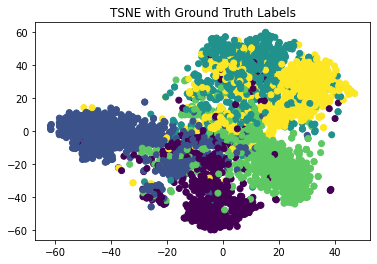

In [ ]:
x_t, y_nt = [tsne_trans[:, 0], tsne_trans[:, 1]]
plt.scatter(x_t, y_nt, c=y_all)
plt.title("TSNE with Ground Truth Labels")
plt.show()

# Question 24

In [ ]:
SVD_list = [50]
K_mean_list = [5]
history = {}

for s in SVD_list:
  for k in K_mean_list:
    k_means = KMeans(n_clusters=k, max_iter=1000, n_init=30, random_state=0)
    svd = TruncatedSVD(n_components=s, random_state = 42)
    y_pred = k_means.fit_predict(svd.fit_transform(f_all))
    history["SVD" + str(s) + " + "+ "K_MEAN + " + str(k)] = adjusted_rand_score(y_all,y_pred)



In [ ]:
history

{'SVD50 + K_MEAN + 5': 0.19146937613851173}

In [ ]:
SVD_list = [50]


for s in SVD_list:
    svd = TruncatedSVD(n_components=s, random_state = 42)
    aggcluster = AgglomerativeClustering(n_clusters=5, linkage='ward')
    y_pred = aggcluster.fit_predict(svd.fit_transform(f_all))
    print("SVD" + str(s) + " + "+ "AGG + 5" )
    history["SVD" + str(s) + " + "+ "AGG + 5"] = adjusted_rand_score(y_all,y_pred)


SVD50 + AGG + 5


In [ ]:
history

{'SVD50 + K_MEAN + 5': 0.19146937613851173,
 'SVD50 + AGG + 5': 0.2334745470751877}

In [ ]:
SVD_list = [50]

min_clust_size = [5,50,100]
min_sample = [5,20]
for m in min_clust_size:
  for sa in min_sample:
    for s in SVD_list:
      svd = TruncatedSVD(n_components=s, random_state = 42)
      hdb_clust = hdbscan.HDBSCAN(min_cluster_size=m,min_samples=sa)
      y_pred = hdb_clust.fit_predict(svd.fit_transform(f_all))
      print("SVD" + str(s) + " + "+ "HDB + "+str(m) +"sample  " + str(sa))
      history["SVD" + str(s) + " + "+ "HDB + " + str(m)+"sample  " + str(sa)] = adjusted_rand_score(y_all,y_pred)


SVD50 + HDB + 5sample  5
SVD50 + HDB + 5sample  20
SVD50 + HDB + 50sample  5
SVD50 + HDB + 50sample  20
SVD50 + HDB + 100sample  5
SVD50 + HDB + 100sample  20


In [ ]:
history

{'SVD50 + K_MEAN + 5': 0.19146937613851173,
 'SVD50 + AGG + 5': 0.2334745470751877,
 'SVD50 + HDB + 5sample  5': 0.005498837928082272,
 'SVD50 + HDB + 5sample  20': 0.0,
 'SVD50 + HDB + 50sample  5': 0.0,
 'SVD50 + HDB + 50sample  20': 0.0,
 'SVD50 + HDB + 100sample  5': 0.0,
 'SVD50 + HDB + 100sample  20': 0.0}

In [ ]:
pip install umap-learn


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 88.2/88.2 KB 6.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 56.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for umap-learn: filename=umap_learn-0.5.3-py3-none-any.whl size=82829 sha256=cedd1f469ae9c0eccf6a07aab34b9e1a2208a7999bfb675225ff3856cae79f5b
  Stored in directory: /root/.cache/pip/wheels/a9/3a/67/06a8950e053725912e6a8c42c4a3a241410f6487b8402542ea
  Created wheel for pynndescent: filename=pynndescent-0.5.8-py3-none-any.whl size=55513 sha256=f290e1893fddd335fc40514b27d00b8339d7ac1bc670f21429cb9e2f2d50824a
  Stored in directory: /root/.cache/pip/wheels/1c/63/3a/29954bca1a27ba100ed8c27973a78cb71b43dc67aed62e80c3
Successfully built umap-learn pynndescent


In [ ]:
import umap

n_components = [50]
K_mean_list = [5]

for n in n_components:
    for k in K_mean_list:
      umap_model = umap.UMAP(n_components=n, metric="cosine")
      kmeans = KMeans(n_clusters=k, init='random', n_init=30, max_iter=1000, random_state=0)
      y_pred = kmeans.fit_predict(umap_model.fit_transform(f_all))
      print("UMAP" + str(n) + " + "+ "K_MEAN + "+str(k))
      history["UMAP" + str(n) + " + "+ "K_MEAN + " + str(k)] = adjusted_rand_score(y_all,y_pred)

UMAP50 + K_MEAN + 5


In [ ]:
history

{'SVD50 + K_MEAN + 5': 0.19146937613851173,
 'SVD50 + AGG + 5': 0.2334745470751877,
 'SVD50 + HDB + 5sample  5': 0.005498837928082272,
 'SVD50 + HDB + 5sample  20': 0.0,
 'SVD50 + HDB + 50sample  5': 0.0,
 'SVD50 + HDB + 50sample  20': 0.0,
 'SVD50 + HDB + 100sample  5': 0.0,
 'SVD50 + HDB + 100sample  20': 0.0,
 'UMAP50 + K_MEAN + 5': 0.4676822988641824}

In [ ]:
n_components = [50]

for N in n_components:
    umap_model = umap.UMAP(n_components=N, metric="cosine")
    aggcluster = AgglomerativeClustering(n_clusters=5, linkage='ward')
    y_pred = aggcluster.fit_predict(umap_model.fit_transform(f_all))
    print("UMAP" + str(N) + " + "+ "AGG + "+str(5))
    history["UMAP" + str(N) + " + "+ "AGG + " + str(5)] = adjusted_rand_score(y_all,y_pred)


UMAP50 + AGG + 5


In [ ]:
history

{'SVD50 + K_MEAN + 5': 0.19146937613851173,
 'SVD50 + AGG + 5': 0.2334745470751877,
 'SVD50 + HDB + 5sample  5': 0.005498837928082272,
 'SVD50 + HDB + 5sample  20': 0.0,
 'SVD50 + HDB + 50sample  5': 0.0,
 'SVD50 + HDB + 50sample  20': 0.0,
 'SVD50 + HDB + 100sample  5': 0.0,
 'SVD50 + HDB + 100sample  20': 0.0,
 'UMAP50 + K_MEAN + 5': 0.4676822988641824,
 'UMAP50 + AGG + 5': 0.48631519971009973}

In [ ]:
n_components = [50]

min_clust_size = [5,10]
min_sample = [5,10]
for m in min_clust_size:
  for sa in min_sample:
    for N in n_components:
      umap_model = umap.UMAP(n_components=n, metric="cosine")
      hdb_clust = hdbscan.HDBSCAN(min_cluster_size=m,min_samples = sa)
      y_pred = hdb_clust.fit_predict(umap_model.fit_transform(f_all))
      print("UMAP" + str(N) + " + "+ "HDB + "+str(m) +"sample  " + str(sa))
      history["UMAP" + str(N) + " + "+ "HDB + "+str(m) +"sample  " + str(sa)] = adjusted_rand_score(y_all,y_pred)


UMAP50 + HDB + 5sample  5
UMAP50 + HDB + 5sample  10
UMAP50 + HDB + 10sample  5
UMAP50 + HDB + 10sample  10


In [ ]:
history

{'SVD50 + K_MEAN + 5': 0.19146937613851173,
 'SVD50 + AGG + 5': 0.2334745470751877,
 'SVD50 + HDB + 5sample  5': 0.005498837928082272,
 'SVD50 + HDB + 5sample  20': 0.0,
 'SVD50 + HDB + 50sample  5': 0.0,
 'SVD50 + HDB + 50sample  20': 0.0,
 'SVD50 + HDB + 100sample  5': 0.0,
 'SVD50 + HDB + 100sample  20': 0.0,
 'UMAP50 + K_MEAN + 5': 0.4676822988641824,
 'UMAP50 + AGG + 5': 0.48631519971009973,
 'UMAP50 + HDB + 5sample  5': 0.09411014415380671,
 'UMAP50 + HDB + 5sample  10': 0.09494009559863244,
 'UMAP50 + HDB + 10sample  5': 0.09494009559863244,
 'UMAP50 + HDB + 10sample  10': 0.09483164455701254}

In [ ]:
class Autoencoder(torch.nn.Module, TransformerMixin):
    def __init__(self, n_components):
        super().__init__()
        self.n_components = n_components
        self.n_features = None  # to be determined with data
        self.encoder = None
        self.decoder = None
        
    def _create_encoder(self):
        return nn.Sequential(
            nn.Linear(4096, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), nn.Linear(640, 120), nn.ReLU(True), nn.Linear(120, self.n_components))
    
    def _create_decoder(self):
        return nn.Sequential(
            nn.Linear(self.n_components, 120),
            nn.ReLU(True),
            nn.Linear(120, 640),
            nn.ReLU(True),
            nn.Linear(640, 1280),
            nn.ReLU(True), nn.Linear(1280, 4096))
    
    def forward(self, X):
        encoded = self.encoder(X)
        decoded = self.decoder(encoded)
        return decoded
    
    def fit(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.n_features = X.shape[1]
        self.encoder = self._create_encoder()
        self.decoder = self._create_decoder()
        self.cuda()
        self.train()
        
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_,) in dataloader:
                X_ = X_.cuda()
                # ===================forward=====================
                output = self(X_)
                loss = criterion(output, X_)
                # ===================backward====================
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        return self     
        
    def transform(self, X):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        self.eval()
        with torch.no_grad():
            return self.encoder(X).cpu().numpy()

In [ ]:

K_mean_list = [5]


for k in K_mean_list:
  auto_encode = Autoencoder(50)
  kmeans = KMeans(n_clusters=k, init='random', n_init=30, max_iter=1000, random_state=0)
  y_pred = kmeans.fit_predict(auto_encode.fit_transform(f_all))
  print("AUTO" + str(n) + " + "+ "K_MEAN + "+str(k))
  history["AUTO" + str(n) + " + "+ "K_MEAN + " + str(k)] = adjusted_rand_score(y_all,y_pred)

100%|██████████| 100/100 [00:23<00:00,  4.23it/s]


AUTO50 + K_MEAN + 5


In [ ]:
history

{'SVD50 + K_MEAN + 5': 0.19146937613851173,
 'SVD50 + AGG + 5': 0.2334745470751877,
 'SVD50 + HDB + 5sample  5': 0.005498837928082272,
 'SVD50 + HDB + 5sample  20': 0.0,
 'SVD50 + HDB + 50sample  5': 0.0,
 'SVD50 + HDB + 50sample  20': 0.0,
 'SVD50 + HDB + 100sample  5': 0.0,
 'SVD50 + HDB + 100sample  20': 0.0,
 'UMAP50 + K_MEAN + 5': 0.4676822988641824,
 'UMAP50 + AGG + 5': 0.48631519971009973,
 'UMAP50 + HDB + 5sample  5': 0.09411014415380671,
 'UMAP50 + HDB + 5sample  10': 0.09494009559863244,
 'UMAP50 + HDB + 10sample  5': 0.09494009559863244,
 'UMAP50 + HDB + 10sample  10': 0.09483164455701254,
 'AUTO50 + K_MEAN + 5': 0.1988387986337919}

In [ ]:
n_components = [50]

for N in n_components:
    auto_encode = Autoencoder(50)
    aggcluster = AgglomerativeClustering(n_clusters=5, linkage='ward')
    y_pred = aggcluster.fit_predict(auto_encode.fit_transform(f_all))
    print("AUTO" + str(N) + " + "+ "AGG + "+str(5))
    history["AUTO" + str(N) + " + "+ "AGG + " + str(5)] = adjusted_rand_score(y_all,y_pred)


100%|██████████| 100/100 [00:22<00:00,  4.44it/s]


AUTO50 + AGG + 5


In [ ]:
history

{'SVD50 + K_MEAN + 5': 0.19146937613851173,
 'SVD50 + AGG + 5': 0.2334745470751877,
 'SVD50 + HDB + 5sample  5': 0.005498837928082272,
 'SVD50 + HDB + 5sample  20': 0.0,
 'SVD50 + HDB + 50sample  5': 0.0,
 'SVD50 + HDB + 50sample  20': 0.0,
 'SVD50 + HDB + 100sample  5': 0.0,
 'SVD50 + HDB + 100sample  20': 0.0,
 'UMAP50 + K_MEAN + 5': 0.4676822988641824,
 'UMAP50 + AGG + 5': 0.48631519971009973,
 'UMAP50 + HDB + 5sample  5': 0.09411014415380671,
 'UMAP50 + HDB + 5sample  10': 0.09494009559863244,
 'UMAP50 + HDB + 10sample  5': 0.09494009559863244,
 'UMAP50 + HDB + 10sample  10': 0.09483164455701254,
 'AUTO50 + K_MEAN + 5': 0.1988387986337919,
 'AUTO50 + AGG + 5': 0.14208845180661883}

In [ ]:
n_components = [50]

min_clust_size = [5,10]
min_sample = [5,10]
for m in min_clust_size:
  for sa in min_sample:
    for N in n_components:
      auto_encode = Autoencoder(50)
      hdb_clust = hdbscan.HDBSCAN(min_cluster_size=m,min_samples = sa)
      y_pred = hdb_clust.fit_predict(auto_encode.fit_transform(f_all))
      print("AUTO" + str(N) + " + "+ "HDB + "+str(m) +"sample  " + str(sa))
      history["AUTO" + str(N) + " + "+ "HDB + "+str(m) +"sample  " + str(sa)] = adjusted_rand_score(y_all,y_pred)


100%|██████████| 100/100 [00:22<00:00,  4.42it/s]


AUTO50 + HDB + 5sample  5


100%|██████████| 100/100 [00:24<00:00,  4.06it/s]


AUTO50 + HDB + 5sample  10


100%|██████████| 100/100 [00:22<00:00,  4.37it/s]


AUTO50 + HDB + 10sample  5


100%|██████████| 100/100 [00:22<00:00,  4.39it/s]


AUTO50 + HDB + 10sample  10


In [ ]:
history

{'SVD50 + K_MEAN + 5': 0.19146937613851173,
 'SVD50 + AGG + 5': 0.2334745470751877,
 'SVD50 + HDB + 5sample  5': 0.005498837928082272,
 'SVD50 + HDB + 5sample  20': 0.0,
 'SVD50 + HDB + 50sample  5': 0.0,
 'SVD50 + HDB + 50sample  20': 0.0,
 'SVD50 + HDB + 100sample  5': 0.0,
 'SVD50 + HDB + 100sample  20': 0.0,
 'UMAP50 + K_MEAN + 5': 0.4676822988641824,
 'UMAP50 + AGG + 5': 0.48631519971009973,
 'UMAP50 + HDB + 5sample  5': 0.09411014415380671,
 'UMAP50 + HDB + 5sample  10': 0.09494009559863244,
 'UMAP50 + HDB + 10sample  5': 0.09494009559863244,
 'UMAP50 + HDB + 10sample  10': 0.09483164455701254,
 'AUTO50 + K_MEAN + 5': 0.1988387986337919,
 'AUTO50 + AGG + 5': 0.14208845180661883,
 'AUTO50 + HDB + 5sample  5': 0.020317450403088272,
 'AUTO50 + HDB + 5sample  10': 0.023403788945569347,
 'AUTO50 + HDB + 10sample  5': 0.001313600583448493,
 'AUTO50 + HDB + 10sample  10': 0.0}

In [ ]:
K_mean_list = [5]


for k in K_mean_list:
  kmeans = KMeans(n_clusters=k, init='random', n_init=30, max_iter=1000, random_state=0)
  y_pred = kmeans.fit_predict(f_all)
  print("NONE"  + " + "+ "K_MEAN + "+str(k))
  history["NONE"  + " + "+ "K_MEAN + " + str(k)] = adjusted_rand_score(y_all,y_pred)

NONE + K_MEAN + 5


In [ ]:
history

{'SVD50 + K_MEAN + 5': 0.19146937613851173,
 'SVD50 + AGG + 5': 0.2334745470751877,
 'SVD50 + HDB + 5sample  5': 0.005498837928082272,
 'SVD50 + HDB + 5sample  20': 0.0,
 'SVD50 + HDB + 50sample  5': 0.0,
 'SVD50 + HDB + 50sample  20': 0.0,
 'SVD50 + HDB + 100sample  5': 0.0,
 'SVD50 + HDB + 100sample  20': 0.0,
 'UMAP50 + K_MEAN + 5': 0.4676822988641824,
 'UMAP50 + AGG + 5': 0.48631519971009973,
 'UMAP50 + HDB + 5sample  5': 0.09411014415380671,
 'UMAP50 + HDB + 5sample  10': 0.09494009559863244,
 'UMAP50 + HDB + 10sample  5': 0.09494009559863244,
 'UMAP50 + HDB + 10sample  10': 0.09483164455701254,
 'AUTO50 + K_MEAN + 5': 0.1988387986337919,
 'AUTO50 + AGG + 5': 0.14208845180661883,
 'AUTO50 + HDB + 5sample  5': 0.020317450403088272,
 'AUTO50 + HDB + 5sample  10': 0.023403788945569347,
 'AUTO50 + HDB + 10sample  5': 0.001313600583448493,
 'AUTO50 + HDB + 10sample  10': 0.0,
 'NONE50 + K_MEAN + 5': 0.19447072328729068,
 'NONE + K_MEAN + 5': 0.19447072328729068}

In [ ]:

aggcluster = AgglomerativeClustering(n_clusters=5, linkage='ward')
y_pred = aggcluster.fit_predict(f_all)
print("NONE"  + " + "+ "AGG + "+str(5))
history["NONE"  + " + "+ "AGG + " + str(5)] = adjusted_rand_score(y_all,y_pred)


NONE + AGG + 5


In [ ]:
history

{'SVD50 + K_MEAN + 5': 0.19146937613851173,
 'SVD50 + AGG + 5': 0.2334745470751877,
 'SVD50 + HDB + 5sample  5': 0.005498837928082272,
 'SVD50 + HDB + 5sample  20': 0.0,
 'SVD50 + HDB + 50sample  5': 0.0,
 'SVD50 + HDB + 50sample  20': 0.0,
 'SVD50 + HDB + 100sample  5': 0.0,
 'SVD50 + HDB + 100sample  20': 0.0,
 'UMAP50 + K_MEAN + 5': 0.4676822988641824,
 'UMAP50 + AGG + 5': 0.48631519971009973,
 'UMAP50 + HDB + 5sample  5': 0.09411014415380671,
 'UMAP50 + HDB + 5sample  10': 0.09494009559863244,
 'UMAP50 + HDB + 10sample  5': 0.09494009559863244,
 'UMAP50 + HDB + 10sample  10': 0.09483164455701254,
 'AUTO50 + K_MEAN + 5': 0.1988387986337919,
 'AUTO50 + AGG + 5': 0.14208845180661883,
 'AUTO50 + HDB + 5sample  5': 0.020317450403088272,
 'AUTO50 + HDB + 5sample  10': 0.023403788945569347,
 'AUTO50 + HDB + 10sample  5': 0.001313600583448493,
 'AUTO50 + HDB + 10sample  10': 0.0,
 'NONE50 + K_MEAN + 5': 0.19447072328729068,
 'NONE + K_MEAN + 5': 0.19447072328729068,
 'NONE + AGG + 5': 0.18

In [ ]:
min_clust_size = [5,10]
min_sample = [5,10]
for m in min_clust_size:
  for sa in min_sample:
    
      hdb_clust = hdbscan.HDBSCAN(min_cluster_size=m,min_samples = sa)
      y_pred = hdb_clust.fit_predict(f_all)
      print("NONE"  + " + "+ "HDB + "+str(m) +"sample  " + str(sa))
      history["NONE"  + " + "+ "HDB + "+str(m) +"sample  " + str(sa)] = adjusted_rand_score(y_all,y_pred)


AUTO + HDB + 5sample  5
AUTO + HDB + 5sample  10
AUTO + HDB + 10sample  5
AUTO + HDB + 10sample  10


In [ ]:
history

{'SVD50 + K_MEAN + 5': 0.19146937613851173,
 'SVD50 + AGG + 5': 0.2334745470751877,
 'SVD50 + HDB + 5sample  5': 0.005498837928082272,
 'SVD50 + HDB + 5sample  20': 0.0,
 'SVD50 + HDB + 50sample  5': 0.0,
 'SVD50 + HDB + 50sample  20': 0.0,
 'SVD50 + HDB + 100sample  5': 0.0,
 'SVD50 + HDB + 100sample  20': 0.0,
 'UMAP50 + K_MEAN + 5': 0.4676822988641824,
 'UMAP50 + AGG + 5': 0.48631519971009973,
 'UMAP50 + HDB + 5sample  5': 0.09411014415380671,
 'UMAP50 + HDB + 5sample  10': 0.09494009559863244,
 'UMAP50 + HDB + 10sample  5': 0.09494009559863244,
 'UMAP50 + HDB + 10sample  10': 0.09483164455701254,
 'AUTO50 + K_MEAN + 5': 0.1988387986337919,
 'AUTO50 + AGG + 5': 0.14208845180661883,
 'AUTO50 + HDB + 5sample  5': 0.020317450403088272,
 'AUTO50 + HDB + 5sample  10': 0.023403788945569347,
 'AUTO50 + HDB + 10sample  5': 0.001313600583448493,
 'AUTO50 + HDB + 10sample  10': 0.0,
 'NONE50 + K_MEAN + 5': 0.19447072328729068,
 'NONE + K_MEAN + 5': 0.19447072328729068,
 'NONE + AGG + 5': 0.18

# Question 25

In [ ]:
class MLP(torch.nn.Module):
    def __init__(self, num_features):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(num_features, 1280),
            nn.ReLU(True),
            nn.Linear(1280, 640),
            nn.ReLU(True), 
            nn.Linear(640, 5),
            nn.LogSoftmax(dim=1)
        )
        self.cuda()
    
    
    def forward(self, X):
        return self.model(X)
    
    def train(self, X, y):
        X = torch.tensor(X, dtype=torch.float32, device='cuda')
        y = torch.tensor(y, dtype=torch.int64, device='cuda')

        self.model.train()
        
        criterion = nn.NLLLoss()
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3, weight_decay=1e-5)

        dataset = TensorDataset(X, y)
        dataloader = DataLoader(dataset, batch_size=128, shuffle=True)

        for epoch in tqdm(range(100)):
            for (X_, y_) in dataloader:
                ##################################
                optimizer.zero_grad()

                criterion(self(X_), y_).backward()
                optimizer.step()
                ##################################
                
        return self
    
    def eval(self, X_test, y_test):
        dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32, device='cuda'), torch.tensor(y_test, dtype=torch.int64, device='cuda'))
        dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

        nums = 0 
        count = 0 

        for (X,y) in dataloader : 
          output = self(X)
          nums += y.shape[0]
          count  += (torch.max(output,1)[1]==y).sum().item()

      
        return count/nums

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(f_all, y_all, test_size=0.2)
mlp = MLP(f_all.shape[1])
mlp.train(X_train, y_train)
mlp.eval(X_test,y_test)


100%|██████████| 100/100 [00:08<00:00, 11.13it/s]


0.8923705722070845

In [ ]:
autoencode = Autoencoder(50).fit_transform(f_all)

X_train, X_test, y_train, y_test = train_test_split(autoencode, y_all, test_size=0.2)
mlp = MLP(autoencode.shape[1])
mlp.train(X_train, y_train)
mlp.eval(X_test,y_test)


100%|██████████| 100/100 [00:07<00:00, 13.65it/s]


0.8896457765667575